Dataset siap diproses dengan 1000 baris dan 17 kolom.
Jumlah data duplikat: 0
Tidak ada missing values dalam dataset.


C:\Users\ASUS\AppData\Local\Temp\ipykernel_14192\318324041.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sales_data[column].fillna(sales_data[column].mode()[0], inplace=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_14192\318324041.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves 

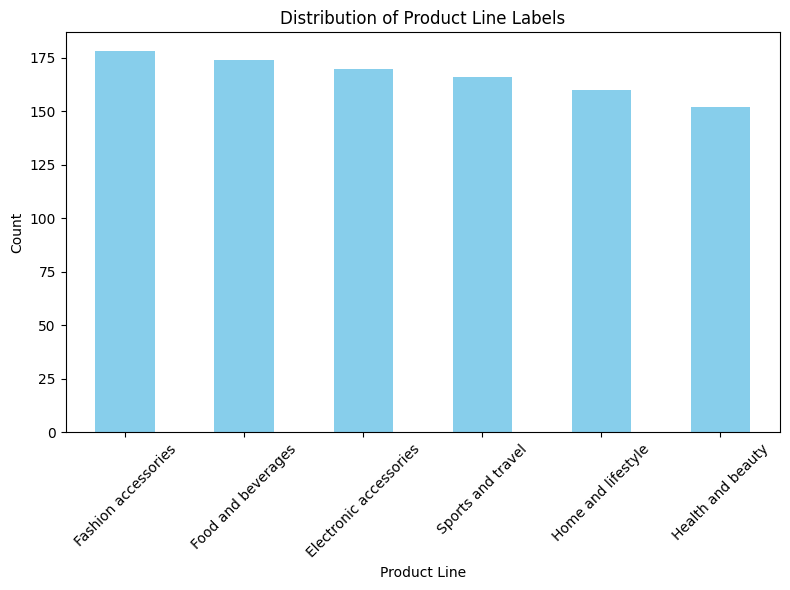

Sample data:
    Invoice ID Branch       City Customer type  Gender  \
0  750-67-8428      A     Yangon        Member  Female   
1  226-31-3081      C  Naypyitaw        Normal  Female   
2  631-41-3108      A     Yangon        Normal    Male   
3  123-19-1176      A     Yangon        Member    Male   
4  373-73-7910      A     Yangon        Normal    Male   

             Product line  Unit price  Quantity   Tax 5%     Total       Date  \
0       Health and beauty       74.69         7  26.1415  548.9715 2019-01-05   
1  Electronic accessories       15.28         5   3.8200   80.2200 2019-03-08   
2      Home and lifestyle       46.33         7  16.2155  340.5255 2019-03-03   
3       Health and beauty       58.22         8  23.2880  489.0480 2019-01-27   
4       Sports and travel       86.31         7  30.2085  634.3785 2019-02-08   

    Time      Payment    cogs  gross margin percentage  gross income  Rating  \
0  13:08      Ewallet  522.83                 4.761905       26.1415   

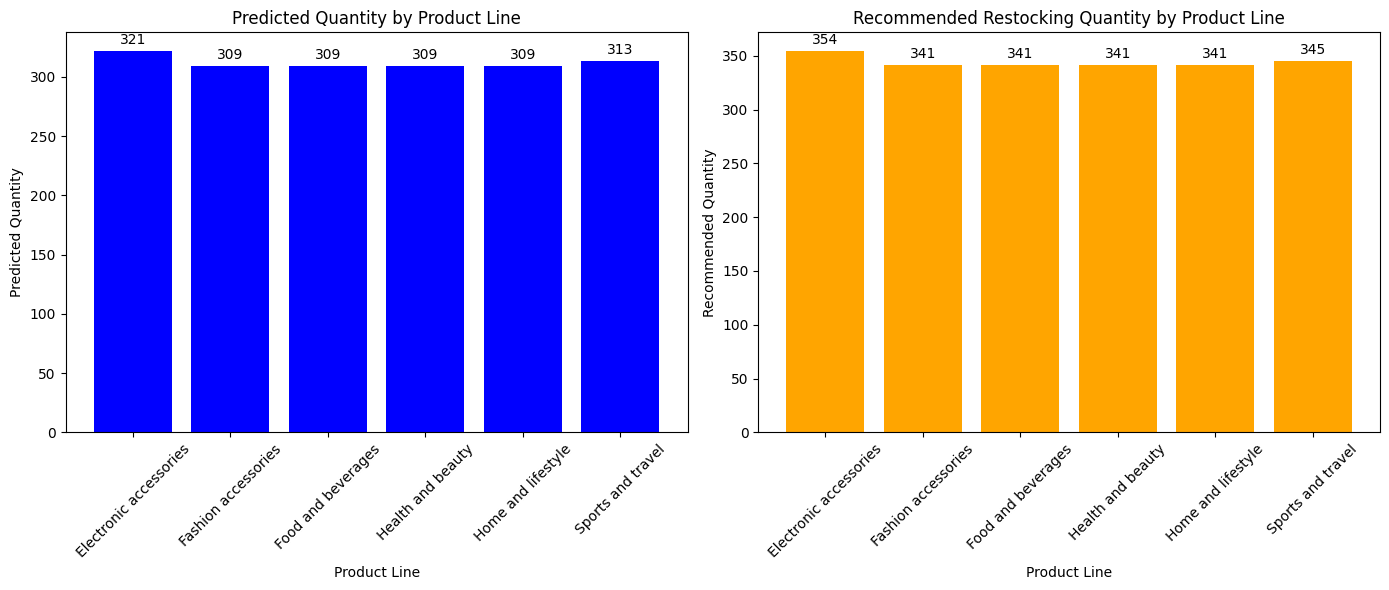

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Membaca data
data_path = '../dataset/supermarket_sales - Sheet1.csv'
sales_data = pd.read_csv(data_path)

# Cek dataset kosong
if sales_data.empty:
    print("Dataset kosong, tidak ada data untuk diproses.")
else:
    print(f"Dataset siap diproses dengan {sales_data.shape[0]} baris dan {sales_data.shape[1]} kolom.")

# Preprocessing: Tangani missing value
for column in sales_data.columns:
    if sales_data[column].dtype == 'object':  # Kolom non-numerik
        sales_data[column].fillna(sales_data[column].mode()[0], inplace=True)
    else:  # Kolom numerik
        sales_data[column].fillna(sales_data[column].median(), inplace=True)
        
# Cek jumlah baris duplikat
duplicate_rows = sales_data[sales_data.duplicated()]
print(f"Jumlah data duplikat: {duplicate_rows.shape[0]}")

# Cek kembali missing value
missing_values = sales_data.isnull().sum().sum()
if missing_values > 0:
    print(f"Ada {missing_values} missing values yang perlu ditangani.")
else:
    print("Tidak ada missing values dalam dataset.")

# Label encoding untuk 'Product line'
if 'Product line' in sales_data.columns:
    sales_data['Product_Label'] = sales_data['Product line'].astype('category').cat.codes

# Menampilkan grafik distribusi label
plt.figure(figsize=(8, 6))
sales_data['Product line'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Product Line Labels')
plt.xlabel('Product Line')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Menambahkan kolom untuk analisis waktu
if 'Date' in sales_data.columns:
    sales_data['Date'] = pd.to_datetime(sales_data['Date'], errors='coerce')  # Tangani tanggal invalid
    sales_data['Month'] = sales_data['Date'].dt.month

# Menampilkan data keseluruhan (5 baris pertama)
print("Sample data:")
print(sales_data.head())

# Mengelompokkan data
monthly_sales = sales_data.groupby(['Product_Label', 'Month']).agg(
    Total_Quantity=('Quantity', 'sum'),
    Average_Unit_Price=('Unit price', 'mean')
).reset_index()

# Menampilkan data atribut yang digunakan dan jumlah kelas
print("Attributes used for training:", ['Month', 'Average_Unit_Price'])
print("Number of classes in Product_Label:", sales_data['Product_Label'].nunique())

# Menentukan fitur dan target
X = monthly_sales[['Month', 'Average_Unit_Price']]
y = monthly_sales['Total_Quantity']

# Standarisasi data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Model KNN
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

# Prediksi
y_pred = knn.predict(X_test)

# Evaluasi menggunakan RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Akurasi
def accuracy(y_test, y_pred):
    return 1 - np.sqrt(np.mean((y_test - y_pred) ** 2)) / np.mean(y_test)

model_accuracy = accuracy(y_test, y_pred) * 100
print(f"Model Accuracy: {model_accuracy:.2f}%")

# Menambahkan bulan berikutnya untuk prediksi
next_month = monthly_sales['Month'].max() + 1
future_data = pd.DataFrame({
    'Month': [next_month] * monthly_sales['Product_Label'].nunique(),
    'Average_Unit_Price': monthly_sales.groupby('Product_Label')['Average_Unit_Price'].mean().values,
    'Product_Label': monthly_sales['Product_Label'].unique()
})

# Mapping label numerik kembali ke nama produk
product_names = sales_data[['Product_Label', 'Product line']].drop_duplicates()
future_data = future_data.merge(product_names, on='Product_Label', how='left')

# Standarisasi data bulan depan
future_data_scaled = scaler.transform(future_data[['Month', 'Average_Unit_Price']])

# Prediksi untuk bulan depan
future_data['Predicted_Quantity'] = knn.predict(future_data_scaled)

# Menambahkan kolom rekomendasi stok
future_data['Recommended_Quantity'] = np.ceil(future_data['Predicted_Quantity'] * 1.1)

# Visualisasi dengan dua grafik
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Grafik Predicted Quantity
rects1 = ax1.bar(future_data['Product line'], future_data['Predicted_Quantity'], color='blue')
ax1.set_title('Predicted Quantity by Product Line')
ax1.set_xlabel('Product Line')
ax1.set_ylabel('Predicted Quantity')
ax1.tick_params(axis='x', rotation=45)

# Menambahkan label pada setiap batang diagram (jumlah prediksi)
for rect in rects1:
    height = rect.get_height()
    ax1.annotate(f'{int(height)}',
                 xy=(rect.get_x() + rect.get_width() / 2, height),
                 xytext=(0, 3),  # Offset
                 textcoords="offset points",
                 ha='center', va='bottom')

# Grafik Recommended Quantity
rects2 = ax2.bar(future_data['Product line'], future_data['Recommended_Quantity'], color='orange')
ax2.set_title('Recommended Restocking Quantity by Product Line')
ax2.set_xlabel('Product Line')
ax2.set_ylabel('Recommended Quantity')
ax2.tick_params(axis='x', rotation=45)

# Menambahkan label pada setiap batang diagram (jumlah rekomendasi)
for rect in rects2:
    height = rect.get_height()
    ax2.annotate(f'{int(height)}',
                 xy=(rect.get_x() + rect.get_width() / 2, height),
                 xytext=(0, 3),  # Offset
                 textcoords="offset points",
                 ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [2]:
print(f"Root Mean Squared Error: {rmse}")
print(f"Model Accuracy: {model_accuracy:.2f}%")

Root Mean Squared Error: 33.599851190146666
Model Accuracy: 88.75%


In [3]:
print(f"Model Accuracy: {model_accuracy:.2f}%")

Model Accuracy: 88.75%
